# C_b_2 : Recherche de modèles : Prophet

Utilisons maintenant le modèle développé par Facebook (Meta) pour modéliser des séries temporelles. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import locale
import calendar
import holidays
from rich import print
from datetime import date
from references import *
from src import *

from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

Importing plotly failed. Interactive plots will not work.


'fr_CA.UTF-8'

In [2]:
# %load_ext jupyter_black

import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=55,
    target_version=black.TargetVersion.PY311,
)

---

## Prophet

![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

> Prophet is a framework for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust in regard to missing data and shifts in trend, and typically handles outliers well.


### Exemple qui a inspiré ce sujet 

Rob Mulla

- https://youtu.be/j0eioK5edqg?si=jW2169K9XA5xdbPP  
- https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet-yt/notebook

### Autre exemple avec variables multiples : 

Exemple / explications simples : https://stackoverflow.com/questions/54544285/is-it-possible-to-do-multivariate-multi-step-forecasting-using-fb-prophet

## Import des données et créations des caractéristiques (*features*)

In [3]:
(
    df,
    InfoDates,
) = import_and_create_features_no_categorical(
    lags=[
        1,
        2,
        3,
        4,
        6,
        24,
        364 * 24 * 1,
        364 * 24 * 2,
        364 * 24 * 3,
    ],
    fenetres=[1, 2, 3, 4, 6, 8, 12, 16, 24],
    fin="20221231",
    getInfoDate=True,
)

df = df.dropna()

FEATURES = df.columns.to_list()[
    1:
]  # Enlevons MW en première colonne

## Transformation pour le modèle Prophet

La cible doit être `y` et les valeurs de temps `ds`.

In [4]:
df["ds"] = df.index
df = df.rename(columns={"MW": "y"})

In [5]:
df.head()

,y,Temp,hourofday,quarter,year,dayofyear,dayofmonth,weekofyear,month,dayofweek,season,isWeekend,isHoliday,day_sin,day_cos,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21,Temp_LAG_t-1h,DT_18-21_LAG_t-1h,DT_16-24_LAG_t-1h,DT_18_LAG_t-1h,DT_21_LAG_t-1h,Temp_LAG_t-2h,DT_18-21_LAG_t-2h,DT_16-24_LAG_t-2h,DT_18_LAG_t-2h,DT_21_LAG_t-2h,Temp_LAG_t-3h,DT_18-21_LAG_t-3h,DT_16-24_LAG_t-3h,DT_18_LAG_t-3h,DT_21_LAG_t-3h,Temp_LAG_t-4h,DT_18-21_LAG_t-4h,DT_16-24_LAG_t-4h,DT_18_LAG_t-4h,DT_21_LAG_t-4h,Temp_LAG_t-6h,DT_18-21_LAG_t-6h,DT_16-24_LAG_t-6h,DT_18_LAG_t-6h,DT_21_LAG_t-6h,Temp_LAG_t-24h,DT_18-21_LAG_t-24h,DT_16-24_LAG_t-24h,DT_18_LAG_t-24h,DT_21_LAG_t-24h,Temp_LAG_t-8736h,DT_18-21_LAG_t-8736h,DT_16-24_LAG_t-8736h,DT_18_LAG_t-8736h,DT_21_LAG_t-8736h,Temp_LAG_t-17472h,DT_18-21_LAG_t-17472h,DT_16-24_LAG_t-17472h,DT_18_LAG_t-17472h,DT_21_LAG_t-17472h,Temp_LAG_t-26208h,DT_18-21_LAG_t-26208h,DT_16-24_LAG_t-26208h,DT_18_LAG_t-26208h,DT_21_LAG_t-26208h,Temp_MOYMOBILE_t-1h,DT_18-21_MOYMOBILE_t-1h,DT_16-24_MOYMOBILE_t-1h,DT_18_MOYMOBILE_t-1h,DT_21_MOYMOBILE_t-1h,Temp_MOYMOBILE_t-2h,DT_18-21_MOYMOBILE_t-2h,DT_16-24_MOYMOBILE_t-2h,DT_18_MOYMOBILE_t-2h,DT_21_MOYMOBILE_t-2h,Temp_MOYMOBILE_t-3h,DT_18-21_MOYMOBILE_t-3h,DT_16-24_MOYMOBILE_t-3h,DT_18_MOYMOBILE_t-3h,DT_21_MOYMOBILE_t-3h,Temp_MOYMOBILE_t-4h,DT_18-21_MOYMOBILE_t-4h,DT_16-24_MOYMOBILE_t-4h,DT_18_MOYMOBILE_t-4h,DT_21_MOYMOBILE_t-4h,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-8h,DT_18-21_MOYMOBILE_t-8h,DT_16-24_MOYMOBILE_t-8h,DT_18_MOYMOBILE_t-8h,DT_21_MOYMOBILE_t-8h,Temp_MOYMOBILE_t-12h,DT_18-21_MOYMOBILE_t-12h,DT_16-24_MOYMOBILE_t-12h,DT_18_MOYMOBILE_t-12h,DT_21_MOYMOBILE_t-12h,Temp_MOYMOBILE_t-16h,DT_18-21_MOYMOBILE_t-16h,DT_16-24_MOYMOBILE_t-16h,DT_18_MOYMOBILE_t-16h,DT_21_MOYMOBILE_t-16h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h,ds
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-23 21:00:00,32859.50,-12.3,21,4,2021,357,23,51,12,3,4,0,0,-7.071068e-01,0.707107,-0.132671,0.991160,0.0,30.3,0.0,28.3,30.3,28.3,30.3,33.3,-12.8,30.8,28.8,30.8,33.8,-14.2,32.2,30.2,32.2,35.2,-11.4,29.4,27.4,29.4,32.4,-11.3,29.3,27.3,29.3,32.3,-10.5,28.5,26.5,28.5,31.5,-6.8,24.8,22.8,24.8,27.8,6.3,11.7,9.7,11.7,14.7,-3.5,21.5,19.5,21.5,24.5,-10.0,28.0,26.0,28.0,31.0,-12.3,30.3,28.3,30.3,33.3,-12.55,30.55,28.55,30.55,33.55,-13.100000,31.100000,29.100000,31.100000,34.100000,-12.675,30.675,28.675,30.675,33.675,-12.166667,30.166667,28.166667,30.166667,33.166667,-11.7625,29.7625,27.7625,29.7625,32.7625,-11.850000,29.850000,27.850000,29.850000,32.850000,-12.37500,30.37500,28.37500,30.37500,33.37500,-11.933333,29.933333,27.933333,29.933333,32.933333,2021-12-23 21:00:00
2021-12-23 22:00:00,32274.67,-12.8,22,4,2021,357,23,51,12,3,4,0,0,-5.000000e-01,0.866025,-0.131961,0.991255,0.0,30.8,0.0,28.8,30.8,28.8,30.8,33.8,-12.3,30.3,28.3,30.3,33.3,-12.8,30.8,28.8,30.8,33.8,-14.2,32.2,30.2,32.2,35.2,-11.4,29.4,27.4,29.4,32.4,-11.0,29.0,27.0,29.0,32.0,-8.1,26.1,24.1,26.1,29.1,6.8,11.2,9.2,11.2,14.2,-2.1,20.1,18.1,20.1,23.1,-9.0,27.0,25.0,27.0,30.0,-12.8,30.8,28.8,30.8,33.8,-12.55,30.55,28.55,30.55,33.55,-12.633333,30.633333,28.633333,30.633333,33.633333,-13.025,31.025,29.025,31.025,34.025,-12.466667,30.466667,28.466667,30.466667,33.466667,-12.0375,30.0375,28.0375,30.0375,33.0375,-11.816667,29.816667,27.816667,29.816667,32.816667,-12.31250,30.31250,28.31250,30.31250,33.31250,-12.129167,30.129167,28.129167,30.129167,33.129167,2021-12-23 22:00:00
2021-12-23 23:00:00,31169.27,-12.8,23,4,2021,357,23,51,12,3,4,0,0,-2.588190e-01,0.965926,-0.131250,0.991349,0.0,30.8,0.0,28.8,30.8,28.8,30.8,33.8,-12.8,30.8,28.8,30.8,33.8,-12.3,30.3,28.3,30.3,33.3,-12.8,30.8,28.8,30.8,33.8,-14.2,32.2,30.2,32.2,35.2,-11.3,29.3,27.3,29.3,32.3,-9.0,27.0,25.0,27.0,30.0,7.0,11.0,9.0,11.0,14.0,-1.3,19.3,17

## Création des ensembles d'apprentissage et validation

In [6]:
date_slit = "2022-01-01"

df_train = df.iloc[df.index < date_slit]
df_test = df.iloc[df.index >= date_slit]

## Création du modèle sans les caractéristiques

Le modèle utilisera seulement les dates, mais effectuera une déduction des caractéristiques de date par lui-même. 

In [7]:
m = Prophet()

m.fit(df_train)

forecast = m.predict(df_test.drop(columns="y"))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/egihck8i.json
DEBUG:cmdstanpy:input tempfile: /var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/vpix3pxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/homebrew/anaconda3/envs/sci1402/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49498', 'data', 'file=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/egihck8i.json', 'init=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/vpix3pxa.json', 'output', 'file=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/prophet_modelt952vqa_/prophet_model-20231204222843.csv', 'method=optimize', 'algorithm=lbfgs', 'i

In [8]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01 00:00:00,24947.323573,22694.373939,23910.008162,24947.323573,24947.323573,-1645.062520,-1645.062520,-1645.062520,-1645.062520,-1645.062520,-1645.062520,0.0,0.0,0.0,23302.261053
1,2022-01-01 01:00:00,24891.227646,22205.515272,23461.679801,24887.871974,24894.587627,-2052.431609,-2052.431609,-2052.431609,-2052.431609,-2052.431609,-2052.431609,0.0,0.0,0.0,22838.796037
2,2022-01-01 02:00:00,24835.131718,21862.931665,23144.183827,24818.485673,24852.626820,-2325.341413,-2325.341413,-2325.341413,-2325.341413,-2325.341413,-2325.341413,0.0,0.0,0.0,22509.790305
3,2022-01-01 03:00:00,24779.035790,21775.415084,23044.902682,24749.026419,24817.150756,-2369.779538,-2369.779538,-2369.779538,-2369.779538,-2369.779538,-2369.779538,0.0,0.0,0.0,22409.256252
4,2022-01-01 04:00:00,24722.939862,21961.639554,23241.580182,24674.674855,24784.060418,-2102.489311,-2102.489311,-2102.489311,-2102.489311,-2102.489311,-2102.489311,0.0,0.0,0.0,22620.450551


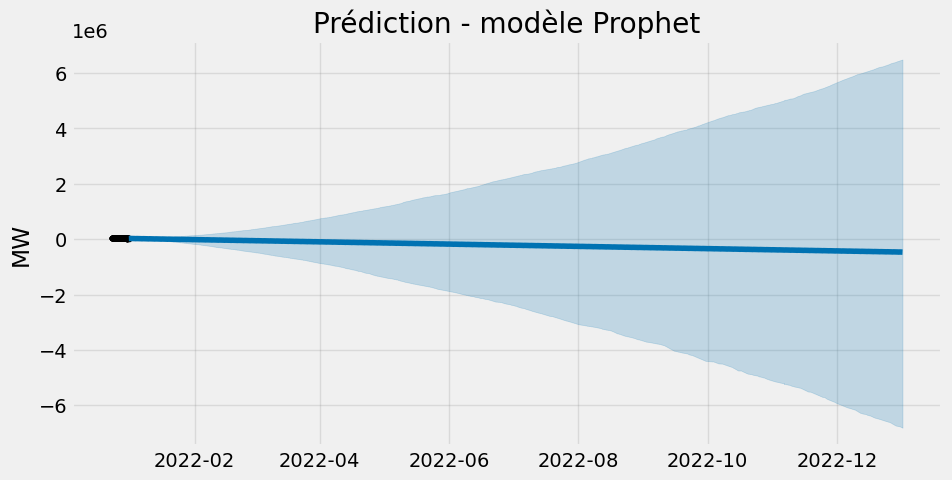

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax)
ax.set_title("Prédiction - modèle Prophet")
ax.set_ylabel("MW")
ax.set_xlabel("")
plt.show()

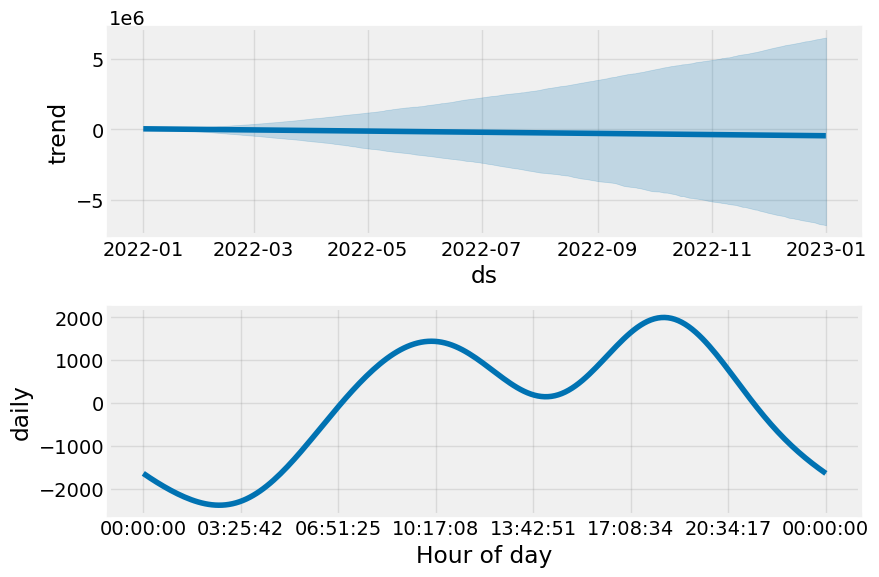

In [10]:
fig = m.plot_components(forecast)
plt.show()

## Comparaison avec les données réelles

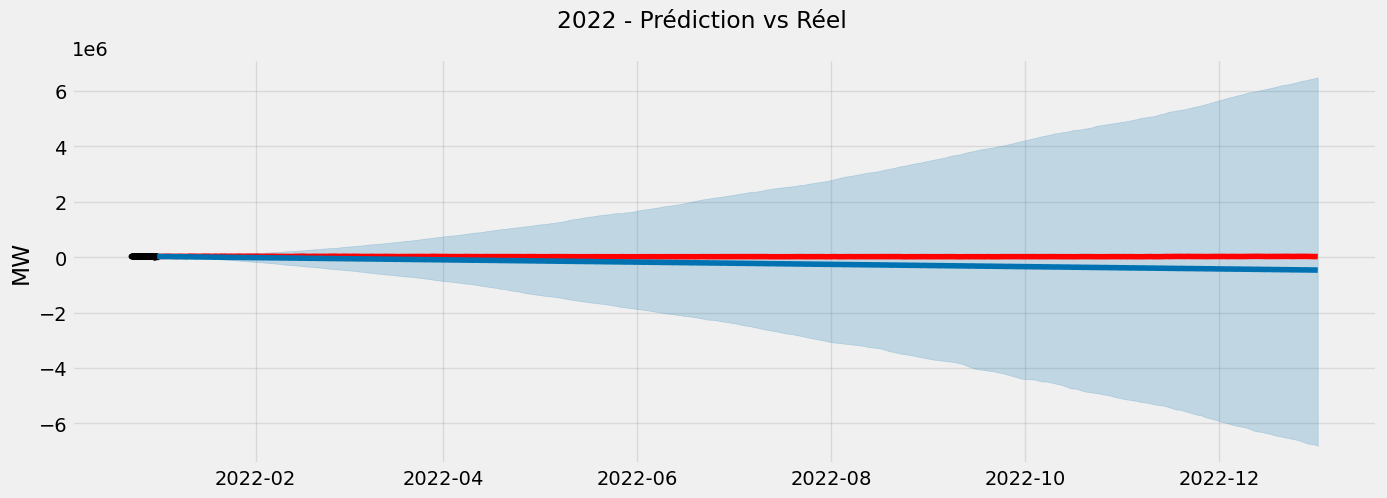

In [11]:
f, ax = plt.subplots(figsize=(15, 5))
ax.plot(
    df_test.index, df_test["y"], color="r"
)  # Données rééelles
fig = m.plot(forecast, ax=ax)  # Prédictions
ax.set_ylabel("MW")
ax.set_xlabel("")
plot = plt.suptitle("2022 - Prédiction vs Réel")

Nous ne pouvons pas voir grand-chose avec cette échelle.

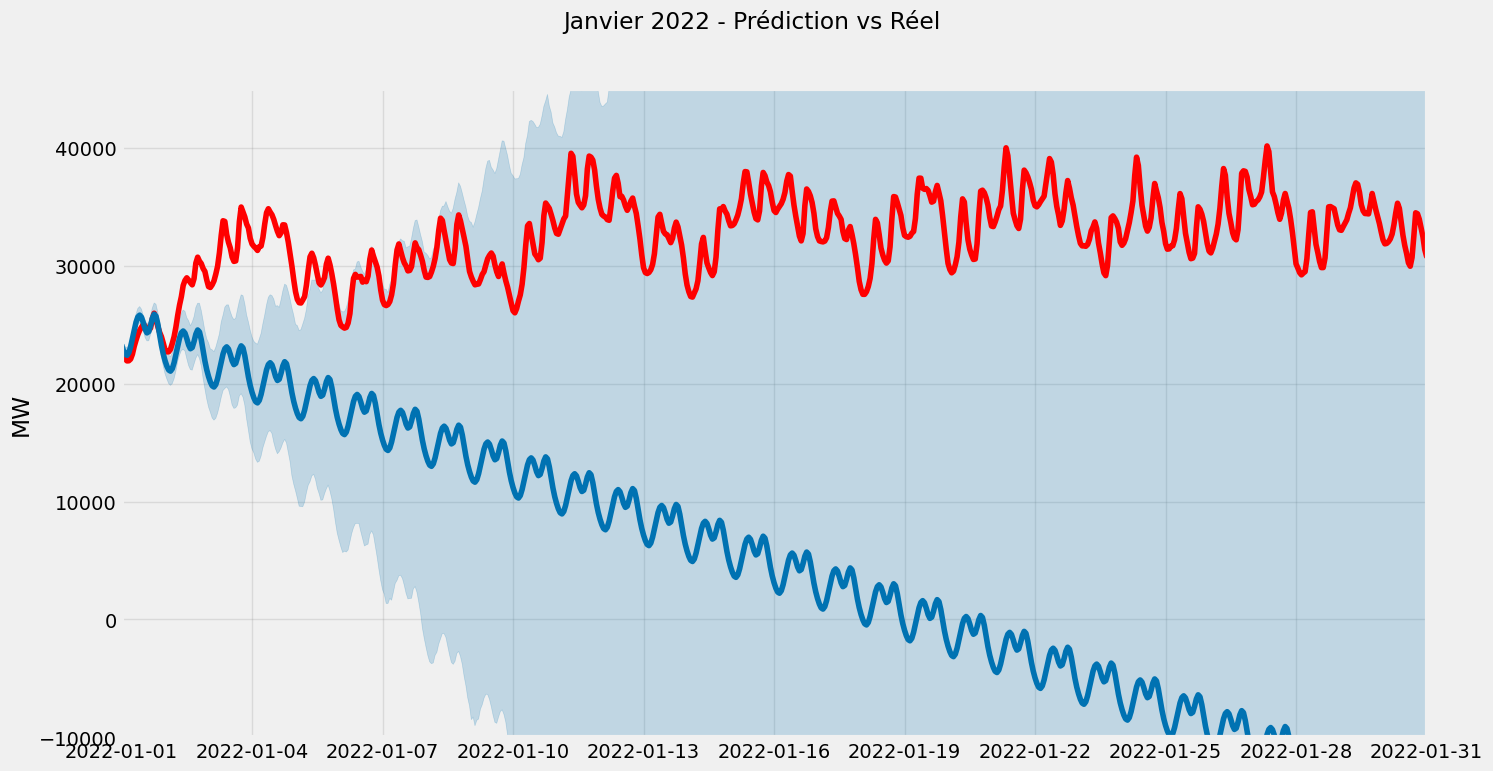

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_test.index, df_test["y"], color="r")
fig = m.plot(forecast, ax=ax)
ax.set_xbound(
    lower=datetime(2022, 1, 1),
    upper=datetime(2022, 1, 31),
)
ax.set_ylim(-10_000, 45_000)
ax.set_ylabel("MW")
ax.set_xlabel("")
plot = plt.suptitle(
    "Janvier 2022 - Prédiction vs Réel"
)

Nous pouvons voir que le modèle décroche complètement. Il est en mesure de reproduire les variations quotidiennes (la double bosse de demande), mais la tendance est grandement à la baisse, projetant des valeurs de demande sous zéro après une vingtaine de jours. 

Cela ne fonctionne pas : essayons avec l'ajout de caractéristiques. 

## Création d'un modèle avec le delat T et la moyenne mobile de la température sur 24h

Ajoutons de 2 caractéristiques : `Temp_MOYMOBILE_t-24h` et `DT_18`

Comme cela fonctionnait bien dans l'autre modèle (importance relative élevée), utilisons une caractéristique supplémentaire dans ce modèle.

In [13]:
m = Prophet()

m.add_regressor("Temp_MOYMOBILE_t-24h")
m.add_regressor("DT_18")

m.fit(df_train)

forecast = m.predict(df_test.drop(columns="y"))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/rhcobyyx.json
DEBUG:cmdstanpy:input tempfile: /var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/nywyup81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/homebrew/anaconda3/envs/sci1402/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99050', 'data', 'file=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/rhcobyyx.json', 'init=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/nywyup81.json', 'output', 'file=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/prophet_modelqhvzoc97/prophet_model-20231204222845.csv', 'method=optimize', 'algorithm=lbfgs', 'i

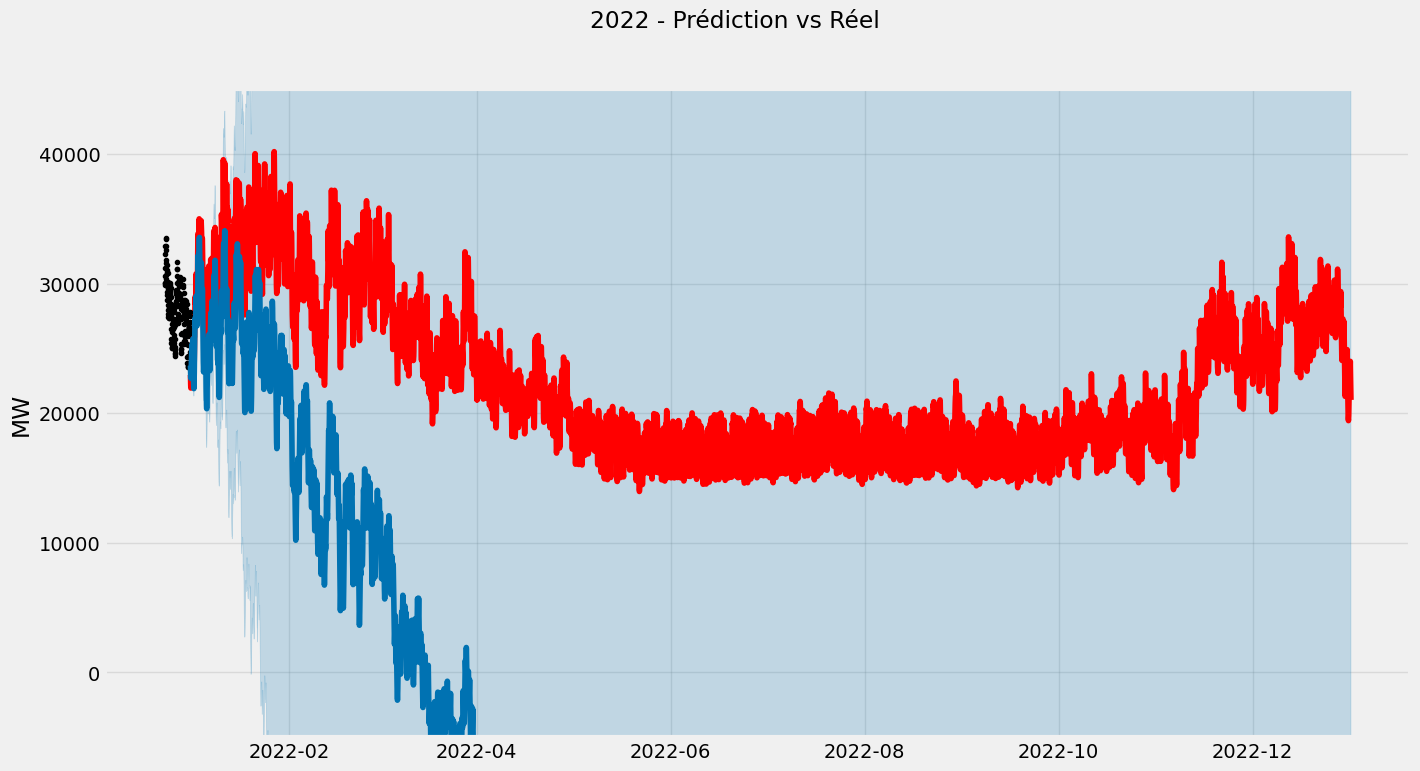

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_test.index, df_test["y"], color="r")
fig = m.plot(forecast, ax=ax)
ax.set_ylabel("MW")
ax.set_xlabel("")
ax.set_ylim(-5_000, 45_000)

plot = plt.suptitle("2022 - Prédiction vs Réel")

Le modèle décroche encore une fois après un mois et demi environ. 

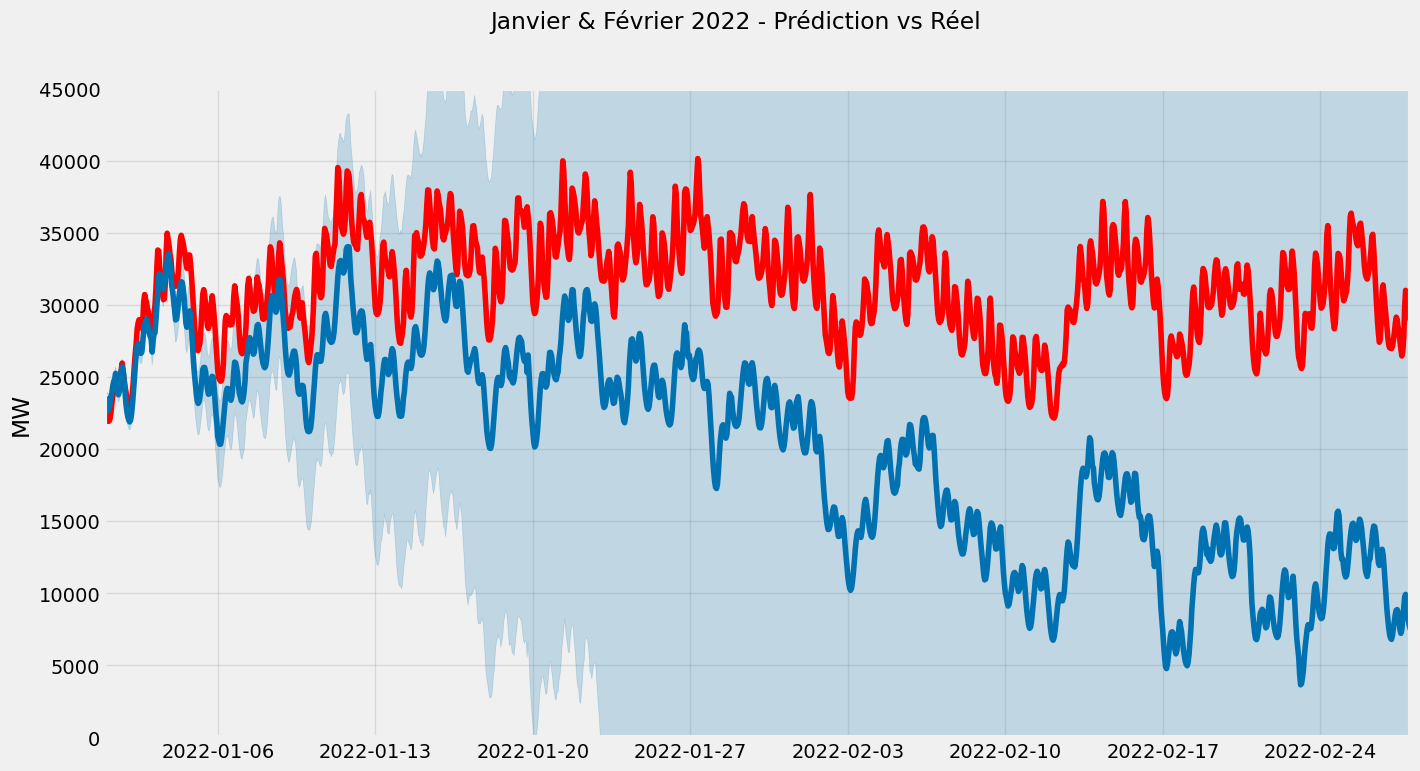

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_test.index, df_test["y"], color="r")
fig = m.plot(forecast, ax=ax)
ax.set_xbound(
    lower=datetime(2022, 1, 1),
    upper=datetime(2022, 2, 28),
)
ax.set_ylim(0, 45_000)
ax.set_ylabel("MW")
ax.set_xlabel("")
plot = plt.suptitle(
    "Janvier & Février 2022 - Prédiction vs Réel"
)

## Création d'un modèle avec toutes les caractéristiques

Comme le modèle s'est amélioré avec l'ajout de caractéristiques, essayons de les ajouter toutes. 

In [16]:
m = Prophet()

for feature in FEATURES:
    m.add_regressor(feature)

m.fit(df_train)

forecast = m.predict(df_test.drop(columns="y"))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/awodpg7b.json
DEBUG:cmdstanpy:input tempfile: /var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/3ii5qbvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/homebrew/anaconda3/envs/sci1402/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56402', 'data', 'file=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/awodpg7b.json', 'init=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/3ii5qbvh.json', 'output', 'file=/var/folders/h1/zbfgvczd009f52sgp7ld62500000gn/T/tmpno48uf50/prophet_modelujvcaqyi/prophet_model-20231204222846.csv', 'method=optimize', 'algorithm=lbfgs', 'i

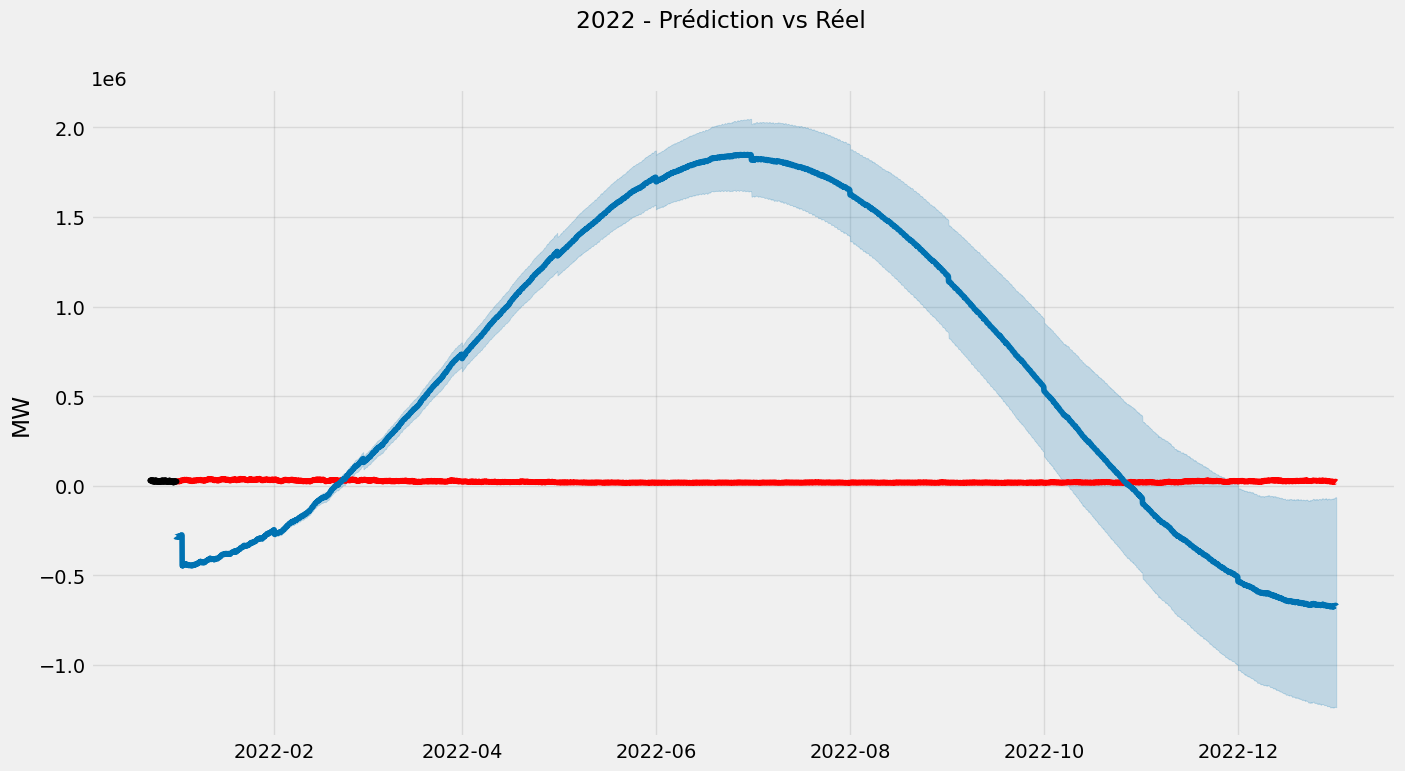

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_test.index, df_test["y"], color="r")
fig = m.plot(forecast, ax=ax)
ax.set_ylabel("MW")
ax.set_xlabel("")
plot = plt.suptitle("2022 - Prédiction vs Réel")

L'ajout de toutes les caractéristiques a complètement bousillé le modèle qui est décroché. 

Pour arriver à un meilleur résultat, il faudrait faire des essais moins radicaux (2, 5, 20 caractéristiques ?)

# Conclusions

Avec ces résultats préliminaires, le temps qui passe dans le projet et les résultats extrêmement intéressants que nous avons obtenus avec **XGBoost**, je prends la décision d'arrêter la modélisation avec Prophet dès maintenant.

Notre temps sera mieux utilisé à peaufiner le modèle de XGBoost que de rendre celui-ci potable. 